# Компания «ГлавРосГосНефть»: выбор скважин для разработки
##  Введение
**Цель работы:**
Определить в каком из регионов прибыль от разработки нефтяных скважин будет наибольшая.

**Задачи, направленные для достижения цели:**
1. Построить модель и оценить её качество. Проанализировать модель.
2. На основании предоставленных данных и прогноза модели отобрать в каждом регионе 500 скважин для разработки.
3. Посчитать прибыль в каждом регионе и определить наиболее оптимальный.

**План работы:**

1. Загрузить данные.
2. Проверить данные на наличие пропусков и дубликатов.
3. Сформировать и обучить модель для прогноза запасов в каждой скважине.
4. Проверить качество работы модели по метрике RMSE.
5. Отобрать 500 скважин в каждом регионе с наибольшим запасом сырья.
6. Посчитать прибыль в каждом регионе методом Bootstrap, формируя выборки по 200 скважин.
7. Сделать выводы о наиболее оптимальном регионе для разработки.

**Описание предоставленных данных**
Предоставлено 3 таблицы с данными геологоразведки трёх регионов:
- geo_data_0.csv;
- geo_data_1.csv;
- geo_data_2.csv.
В каждой таблице присутствуют следующие столбцы:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три геологических признака скважины;
- product — объём запасов в скважине (тыс. баррелей).

**Пояснение к работе**
- При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта в скважине составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов, характеристики месторождений, стоимости сырья и разработки не разглашаются.

## Загрузка и подготовка данных

### Библиотеки

Установим нужные библиотеки и загрузим их.

In [3]:
!pip install shap
!pip install phik

In [4]:
# Общие библиотеки
import pandas as pd
import numpy as np
from math import sqrt

# Библиотеки для построения графиков
import seaborn as sns
import matplotlib.pyplot as plt

# Библиотеки для работы с моделями
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler
)

# Библиотеки для оценки качества и анализа
import shap
from scipy import stats as st
import phik
from phik.report import plot_correlation_matrix
from phik import report


# Обработка ошибок
import warnings
warnings.filterwarnings("ignore")

### Функции

Подготовим функции, которые будут использоваться в работе:

In [5]:
# Функция проверки значений
def data_review(list_df):
    for i in range(len(list_df)):
        print(f'Общая информация в датафрейме region_{i}:\n')
        print(f'{list_df[i].info()}\n\n Первые пять строк датафрейма region_{i}:\n\n {list_df[i].head()}\n')

In [6]:
# Функция поиска дубликатов
def duplicates_in_dataframe(list_df, columns):
    for i in range(len(list_df)):
        print(f'Количество полных дубликатов в датафрейме region_{i}: {list_df[i].duplicated().sum()}')
        for column in columns:
            print (f'Количество дубликатов в столбце {column}: {list_df[i][column].duplicated().sum()}')

In [7]:
def lunge_analysis(df, columns):
    """
    Функция строит боксплоты и гистограммы по переданному списку столбцов.

    Параметры:
        df: датафрейм с нужными значениями.
        columns: список названий столбцов, по которым надо построить диаграммы.

    Возвращает:
        Оформленные боксплоты и гистограммы.

    """
    for column in columns:
        f, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax_1 = sns.histplot(data=df, x=column, ax=ax[0])
        ax_1.set (xlabel=column, ylabel='Количество', title=f'Гистограмма по столбцу {column}')
        ax_2 = sns.boxplot(data=df, y=column, ax=ax[1], width=.2)
        ax_2.set (xlabel=column, ylabel='Значение', title=f'Диаграмма размаха признака {column}')
        plt.show()

In [8]:
def model_train(df):
    """
    Функция подбирает в Pipeline наилучшую модель и возращает 5 переменных.

    Параметры:
        df: датафрейм с нужными значениями.

    Возвращает:
        массив предсказанных значений.
        значение метрики RMSE на валидационной выборке,
        подобранную модель,
        подобранную подготовку данных,
        исходную валидационную выборку

    """    
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(['id', 'product'], axis=1),
        df['product'],
        test_size = TEST_SIZE, 
        random_state = RANDOM_STATE)
    grid_search.fit(X_train, y_train)
    print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
    print('Метрика лучшей модели на кросс-валидационной выборке:', grid_search.best_score_)
# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
    y_test_pred = grid_search.predict(X_test)
    rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    model = grid_search.best_estimator_.named_steps['models']
    preprocessor = grid_search.best_estimator_.named_steps['preprocessor']
    return y_test_pred, rmse, model, preprocessor, X_test

In [9]:
def analysis_model(model, preprocessor, X_test):
    """
    Функция анализирует результаты работы модели методом SHAP.

    Параметры:
        model: модель, которую необходимо интерпретировать.
        preprocessor: метод подготовки данных.
        X_test: данные для прогнозирования, на основе которых модель будет интерпретироваться.

    Возвращает:
        График summary_plot, построенный по результатам интерпретации.
    """     
    X_test_preprocessed = preprocessor.transform(X_test)
    shap_sample = shap.sample(X_test_preprocessed, 1)
    explainer = shap.KernelExplainer(model.predict, shap_sample)
    shap_values = explainer(X_test_preprocessed)
    shap.summary_plot(shap_values, X_test_preprocessed, plot_type="bar", feature_names=['f0', 'f1', 'f2'])

In [10]:
# Функция по расчету прибыли в каждой скважине
def calc_profit_well(df):
    return df['pred_product'] * price_product - target_cost_well

In [11]:
def bootstrap_method_real_product(df):
    """
    Функция методом bootstrap делает выборки из датафрейма и определяет доверительный интервал.

    Параметры:
        df: датафрейм, из которого методом Bootstrap будут делаться выборки.

    Возвращает:
        значения выборок и расчет доверительного интервала.
    """           
    values = []
    for i in range(1000):
        # Сэмплирую датафрейм, сортирую по предсказанным значениям, сбрасываю индексы, чтобы корретно отобрать 200 наилучших.
        subsample = df.sample(n=500, replace=True, random_state=state).sort_values(by='pred_product', ascending=False).reset_index(drop=True)[0:200]
        # Используя реальный product считаю прибыль. Вычисления не сложные, поэтому не использую отдельную функцию.
        subsample['profit'] = subsample['product'] * PRICE_PRODUCT - TARGET_COST_WELL
        values.append(subsample['profit'].sum())


    values = pd.Series(values)

    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average_profit = sum(values) / len(values)
    print(f'Доверительный 95% интервал прибыли: {round(lower / 1000000, 2)} - {round(upper / 1000000, 2)} млн. рублей.')
    print(f'Средняя прибыль составляет {round(average_profit / 1000000, 2)} млн. рублей.')
    return values

### Загрузка данных

Теперь можно загрузить данные:

In [13]:
region_0 = pd.read_csv("F:\Yandex_Practicum\Projects\Project_7\geo_data_0.csv")
region_1 = pd.read_csv("F:\Yandex_Practicum\Projects\Project_7\geo_data_1.csv")
region_2 = pd.read_csv("F:\Yandex_Practicum\Projects\Project_7\geo_data_2.csv")

Подготовим список датафреймов для работы функций:

In [14]:
list_dataframe = [region_0, region_1, region_2]

Познакомимся с данными:

In [15]:
data_review(list_dataframe)

Общая информация в датафрейме region_0:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

 Первые пять строк датафрейма region_0:

       id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

Общая информация в датафрейме region_1:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Nu

### Проверка наличия дубликатов и выбросов

Проверим наличие дубликатов

In [16]:
duplicates_in_dataframe(list_dataframe, ['id'])

Количество полных дубликатов в датафрейме region_0: 0
Количество дубликатов в столбце id: 10
Количество полных дубликатов в датафрейме region_1: 0
Количество дубликатов в столбце id: 4
Количество полных дубликатов в датафрейме region_2: 0
Количество дубликатов в столбце id: 4


Так как природа значений, указанных в столбцах f0, f1, f2 неизвестна, то их анализировать на выбросы не будем. Посмотрим на выбросы и распределение столбец product.

**Анализ данных региона 0**

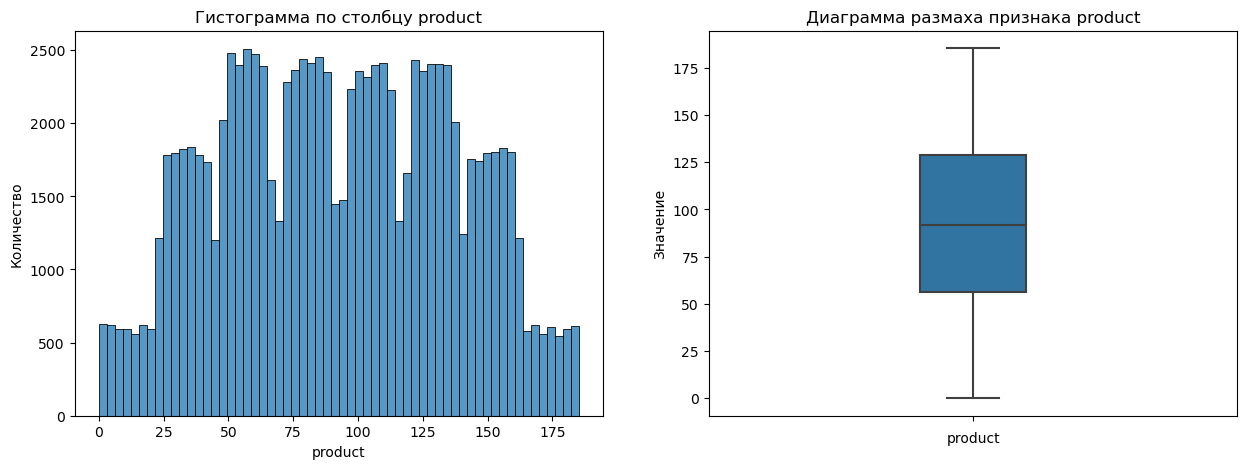

In [17]:
lunge_analysis(region_0, ['product'])

**Анализ данных региона 1**

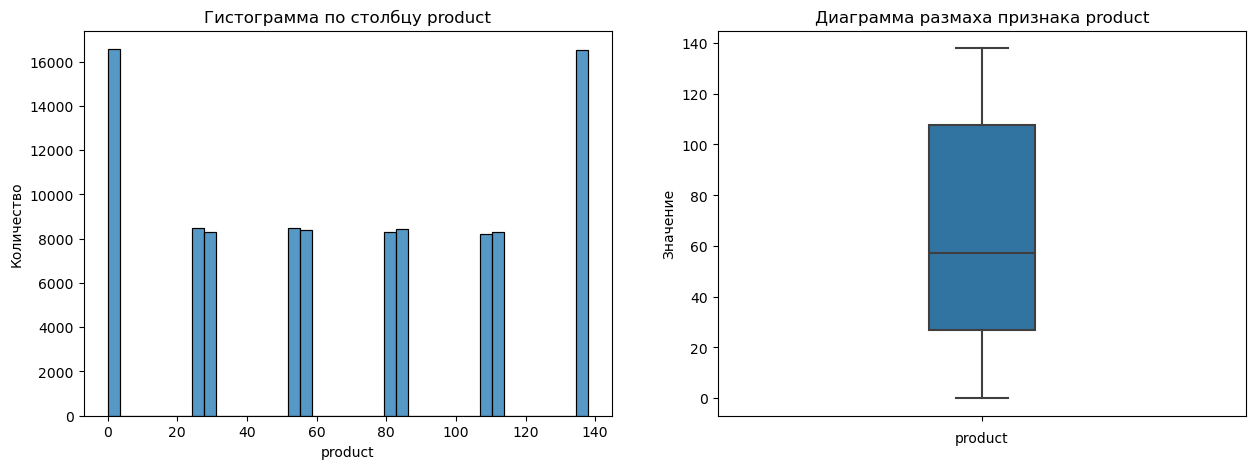

In [18]:
lunge_analysis(region_1, ['product'])

**Анализ данных региона 2**

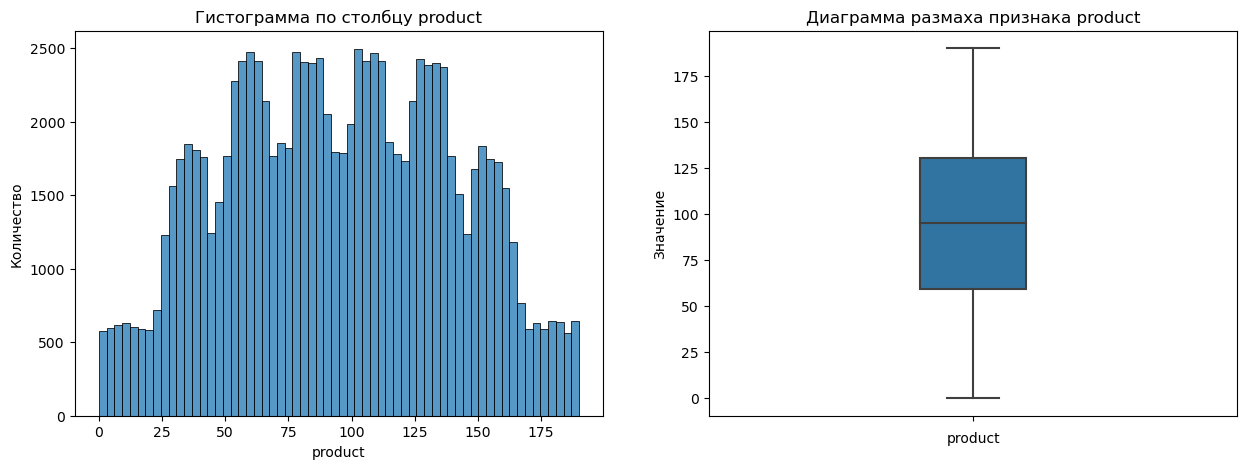

In [19]:
lunge_analysis(region_2, ['product'])

**Итого:**
1. Везде типы переменных определены верно.
2. Пропусков нет.
3. В данных некоторые скважины записаны несколько раз. Их количество очень небольшое, удалять не требуется. 
4. Выбросов нет ни в одном регионе.
5. Распределение в регионах 0 и 2 близко к нормальному, в том же время в регионе 1 очень сильно отличается. Видно, что очень много скважин, где нет продукта совсем или где его очень много.

### Анализ корреляции между признаками

Проанализируем как коррелируют признаки между собой:

**Регион 0:**

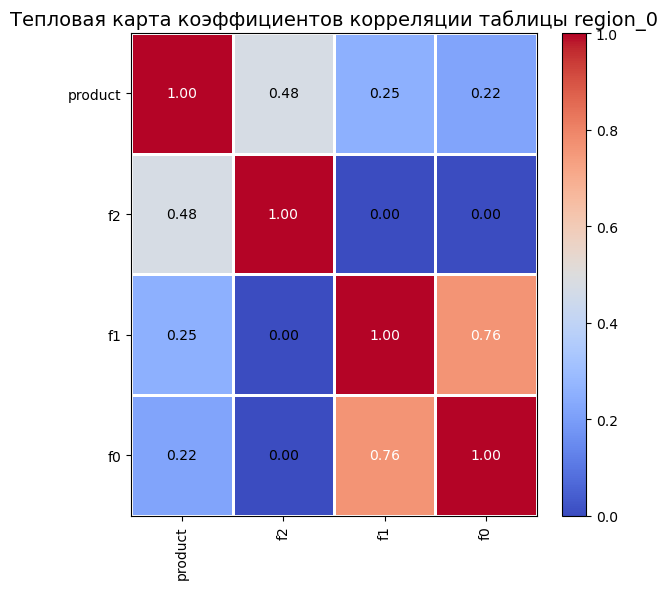

In [20]:
phik_overview = region_0.drop(['id'], axis=1).phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="coolwarm", 
                        title="Тепловая карта коэффициентов корреляции таблицы region_0", 
                        fontsize_factor=1,
                        figsize=(6, 6))
plt.tight_layout()
plt.show()

Наблюдается высокая корреляция между признакми f1 и f0.

**Регион 1:**

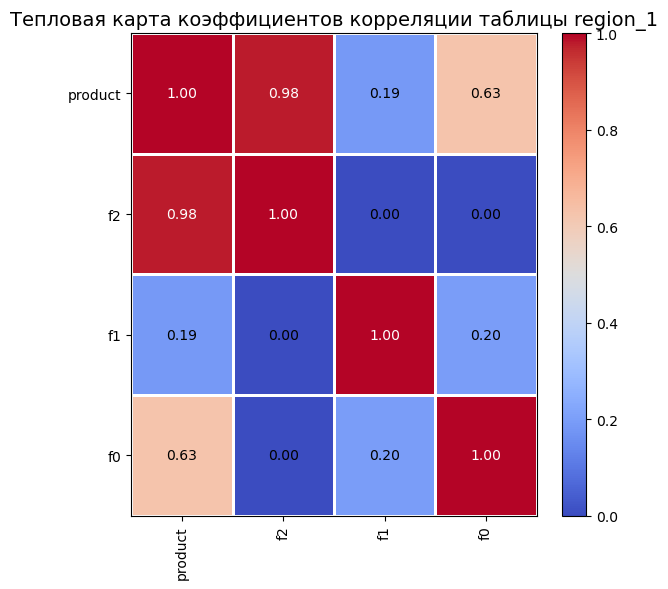

In [21]:
phik_overview = region_1.drop(['id'], axis=1).phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="coolwarm", 
                        title="Тепловая карта коэффициентов корреляции таблицы region_1", 
                        fontsize_factor=1,
                        figsize=(6, 6))
plt.tight_layout()
plt.show()

На основе анализа корреляции можно сделать следующие выводы:
1. Наблюдается мультиколлениарность между признакми f2 и product.
2. Высокий уровень корреляции между признаками f0 и product.  

Возможно, параметр f2 по физической сущности близок к product, но так как нет информации, какой именно признак зашифрован в f2, утверждать однозначно нельзя.


**Регион 2:**

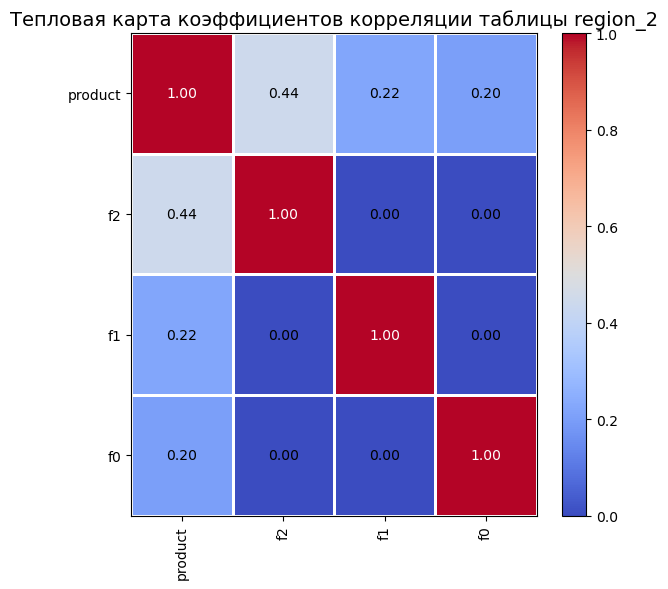

In [22]:
phik_overview = region_2.drop(['id'], axis=1).phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="coolwarm", 
                        title="Тепловая карта коэффициентов корреляции таблицы region_2", 
                        fontsize_factor=1,
                        figsize=(6, 6))
plt.tight_layout()
plt.show()

Сильной корреляции в этом регионе не обнаружено.

**Итого:**  
Среди данных есть сильная корреляция, в том числе мультиколлениарность.

## Обучение и проверка модели

Приступим к формированию моделей. Сперва зададим константы, методы подготовки данных и варианты перебора.

In [23]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [24]:
# сформируем списки с названиями признаков
num_columns = ['f0',
                'f1',
                'f2'
              ]

# сформируем общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# сформируем итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

    
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

### Модель для региона 0

In [25]:
y_test_pred_region_0, rmse_region_0, model_region_0, preprocessor_region_0, X_test_0 = model_train(region_0)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели на кросс-валидационной выборке: -37.67200536313506


Посчитаем средний запас предсказанного сырья на валидационной выборке и выведем RMSE:

In [26]:
print(f'Средний запас сырья на валидационной выборке из региона 0: {round(sum(y_test_pred_region_0) / len(y_test_pred_region_0), 2)}')

Средний запас сырья на валидационной выборке из региона 0: 92.4


In [27]:
print(f'Метрика RMSE на валидационной выборке из региона 0: {rmse_region_0}')

Метрика RMSE на валидационной выборке из региона 0: 37.75660035026169


Проанализируем модель

  0%|          | 0/25000 [00:00<?, ?it/s]

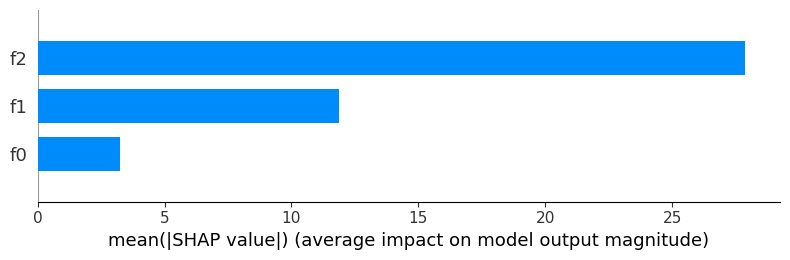

In [28]:
analysis_model(model_region_0, preprocessor_region_0, X_test_0)

**Итого:**
1. RMSE равен 37.75.
2. Наибольший вклад имеет признак f2.

### Модель для региона 1

Теперь обучим модель для регион 1.

In [29]:
y_test_pred_region_1, rmse_region_1, model_region_1, preprocessor_region_1, X_test_1 = model_train(region_1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели на кросс-валидационной выборке: -0.8904559629285673


Посчитаем средний запас предсказанного сырья на валидационной выборке и выведем метрику RMSE.

In [30]:
print(f'Средний запас сырья на валидационной выборке из региона 1: {round(sum(y_test_pred_region_1) / len(y_test_pred_region_1), 2)}')

Средний запас сырья на валидационной выборке из региона 1: 68.71


In [31]:
print(f'Метрика RMSE на валидационной выборке из региона 1: {round(rmse_region_1, 2)}')

Метрика RMSE на валидационной выборке из региона 1: 0.89


Проанализируем результаты модели.

  0%|          | 0/25000 [00:00<?, ?it/s]

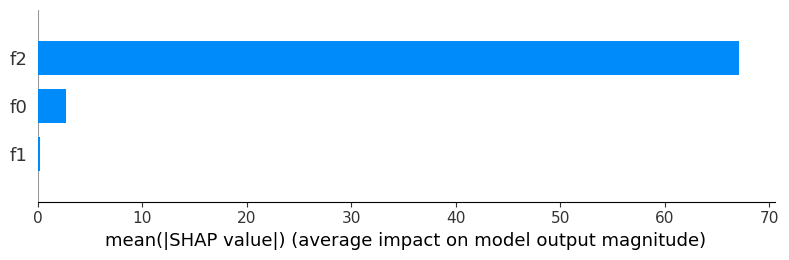

In [32]:
analysis_model(model_region_1, preprocessor_region_1, X_test_1)

**Итого:**

1. RMSE равен 0,89.
2. Наибольший вклад имеет признак f2.

### Модель для региона 2

Теперь обучим модель для региона 2.

In [33]:
y_test_pred_region_2, rmse_region_2, model_region_2, preprocessor_region_2, X_test_2 = model_train(region_2)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели на кросс-валидационной выборке: -40.02698159997838


Посчитаем средний запас предсказанного сырья на валидационной выборке и выведем метрику RMSE.

In [34]:
print(f'Средний запас сырья на валидационной выборке из региона 2: {round(sum(y_test_pred_region_2) / len(y_test_pred_region_2), 2)}')

Средний запас сырья на валидационной выборке из региона 2: 94.77


In [35]:
print(f'Метрика RMSE на валидационной выборке из региона 2: {rmse_region_2}')

Метрика RMSE на валидационной выборке из региона 2: 40.145872311342174


Проанализируем модель

  0%|          | 0/25000 [00:00<?, ?it/s]

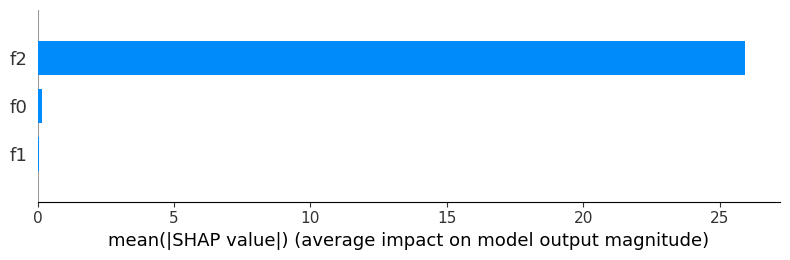

In [36]:
analysis_model(model_region_2, preprocessor_region_2, X_test_2)

**Итого:**

1. RMSE равен 40.15.
2. Наибольший вклад имеет признак f2.

### Общая модель для всех регионов

Теперь обучим модель на всех данных, которые у нас есть. Сперва объединим данные:

In [37]:
all_region = pd.concat([region_0, region_1, region_2], ignore_index=True)

Проверим корректность объединения:

In [38]:
all_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       300000 non-null  object 
 1   f0       300000 non-null  float64
 2   f1       300000 non-null  float64
 3   f2       300000 non-null  float64
 4   product  300000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 11.4+ MB


Теперь обучим модель:

In [39]:
y_test_pred_all_region, rmse_all_region, model_all_region, preprocessor_all_region, X_test_all_region = model_train(all_region)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели на кросс-валидационной выборке: -38.78824438070539


Посчитаем средний запас предсказанного сырья на валидационной выборке и метрику RMSE.

In [40]:
print(f'Средний запас сырья на валидационной выборке по всем регионам: {round(sum(y_test_pred_all_region) / len(y_test_pred_all_region), 2)}')

Средний запас сырья на валидационной выборке по всем регионам: 85.6


In [41]:
print(f'Метрика RMSE на валидационной выборке по всем регионам: {rmse_all_region}')

Метрика RMSE на валидационной выборке по всем регионам: 38.73428082522169


Проанализируем модель.

  0%|          | 0/75000 [00:00<?, ?it/s]

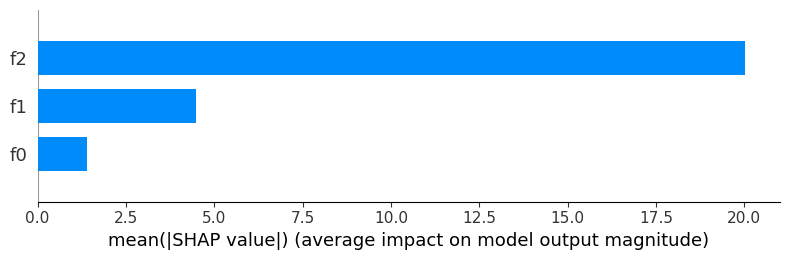

In [42]:
analysis_model(model_all_region, preprocessor_all_region, X_test_all_region)

**Итого:**

1. RMSE равен 38.73.
2. Наибольший вклад имеет признак f2.

### Сравнение всех моделей

Выведем на экраны метрики всех моделей:

In [43]:
print(f'RMSE модели для региона 0 равно {round(rmse_region_0, 2)}.')
print(f'RMSE модели для региона 1 равно {round(rmse_region_1, 2)}.')
print(f'RMSE модели для региона 2 равно {round(rmse_region_2, 2)}.')
print(f'RMSE модели для всех регионов равно {round(rmse_all_region, 2)}.')

RMSE модели для региона 0 равно 37.76.
RMSE модели для региона 1 равно 0.89.
RMSE модели для региона 2 равно 40.15.
RMSE модели для всех регионов равно 38.73.


Как видно, наименьшее, а значит наилучшее значение RMSE, у модели региона 1. Однако данный регион не типичный, его распределение сильно отличается от других и к тому же присутствует мультиколлениарность.

## Подготовка к расчёту прибыли

### Расчёт необходимого объёма сырья в скважине

Рассчитаем, какой объём должен быть в регионе, чтобы считаться безубыточным.

Просвоим имена константам из условия:

In [44]:
PRICE_PRODUCT = 450_000  # Стоимость тысячи баррелей в рублях

In [45]:
WELLS_COST = 10_000_000_000  # Стоимость разработки скважин в регионе в рублях

In [46]:
NUMBER_WELLS = 200  # Планируемое количество скважин к разработке

Теперь рассчитаем стоимость разработки одной скважины, разделив общий бюджет на количество планируемых скважин:

In [47]:
TARGET_COST_WELL = WELLS_COST / NUMBER_WELLS
TARGET_COST_WELL

50000000.0

Стоимость разработки одной скважины составляет 50 000 000 млн. рублей. Посчитаем объем, который должен давать регион:

In [48]:
TARGET_VOLUME_REGION = WELLS_COST / PRICE_PRODUCT
round(TARGET_VOLUME_REGION, 2)

22222.22

Регион должен иметь объём не менее 22 222 тысяч баррелей. Известно, что в регионе планируется разработать только 200 скважин. Тогда посчитаем среднее значение объема на одну скважину:

In [49]:
TARGET_VOLUME_WELL = TARGET_VOLUME_REGION / NUMBER_WELLS
round(TARGET_VOLUME_WELL, 2)

111.11

**Итого:**  
111 баррелей в среднем должна приносить скважина в регионе.

### Расчёт среднего объёма сырья в регионах

Сохраним нужную информацию в отдельные переменные:

In [50]:
production_region_0 = region_0.loc[:, ['id', 'product']]
production_region_1 = region_1.loc[:, ['id', 'product']]
production_region_2 = region_2.loc[:, ['id', 'product']]

Разрабатывать будут только 200 скважин, следовательно, нужно отобрать 200 самых прибыльных. Для этого отсортируем данные по возрастанию и сбросим индексы.

In [51]:
production_region_0 = production_region_0.sort_values(by=['product'], ascending=False)
production_region_0 = production_region_0.reset_index(drop=True)

In [52]:
production_region_1 = production_region_1.sort_values(by=['product'], ascending=False)
production_region_1 = production_region_1.reset_index(drop=True)

In [53]:
production_region_2 = production_region_2.sort_values(by=['product'], ascending=False)
production_region_2 = production_region_2.reset_index(drop=True)

Посчитаем по каждому региону среднее для лучших 200 скважин.

In [54]:
production_region_0.loc[:199]['product'].describe()

count    200.000000
mean     184.833740
std        0.313843
min      184.356455
25%      184.556307
50%      184.798678
75%      185.117594
max      185.364347
Name: product, dtype: float64

In [55]:
production_region_1.loc[:199]['product'].describe()

count    2.000000e+02
mean     1.379454e+02
std      4.843815e-13
min      1.379454e+02
25%      1.379454e+02
50%      1.379454e+02
75%      1.379454e+02
max      1.379454e+02
Name: product, dtype: float64

In [56]:
production_region_2.loc[:199]['product'].describe()

count    200.000000
mean     189.551477
std        0.305075
min      189.024253
25%      189.296699
50%      189.560329
75%      189.826425
max      190.029838
Name: product, dtype: float64

Из данных видно, что в регионе 1 наименьшее среднее количество сырья на скважину. Наибольшее среднее - в регионе 2.  
Теперь проведем анализ вероятности убытков, то есть в каких регионах есть большие шансы набрать в среднем 111 баррелей на скважину. Сформируем нулевую и альтернативную гипотезы.  
**Нулевая гипотеза** - добыча в регионе будет 111,1 баррель на скважину или меньше.  
**Альтернативная гипотеза** - добыча в регионе будет больше 111,11 баррель.  
Уровень значимости установим в 0,025.  
Для проверки гипотезы воспользуемся одновыборочным t-тестом.

### Анализ региона 0

In [57]:
alpha = 0.025

results_product = st.ttest_1samp(
    production_region_0.loc[:199]['product'], TARGET_VOLUME_WELL,
    alternative='greater')

if results_product.pvalue < alpha:
     print('Отвергаем гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

Отвергаем гипотезу.


В регионе 0 вероятность убытков меньше, чем 2,5%.

### Анализ региона 1

In [58]:
alpha = 0.025

results_product = st.ttest_1samp(
    production_region_1.loc[:199]['product'], TARGET_VOLUME_WELL,
    alternative='greater')

if results_product.pvalue < alpha:
     print('Отвергаем гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

Отвергаем гипотезу.


В регионе 1 вероятность убытков меньше, чем 2,5%.

### Анализ региона 2

In [59]:
alpha = 0.025

results_product = st.ttest_1samp(
    production_region_2.loc[:199]['product'], TARGET_VOLUME_WELL,
    alternative='greater')

if results_product.pvalue < alpha:
     print('Отвергаем гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

Отвергаем гипотезу.


В регионе 2 вероятность убытков меньше, чем 2,5%.

### Выводы по разделу 4

1. Если взять 200 самых прибыльных скважин, то в каждом регионе вероятность убытков ниже 2,5%.
2. Необходимый объём в скважине должен быть в среднем не менее 111 тыс. баррелей.

## Расчёт прибыли и рисков 

Ранее уже получили предсказания для каждого региона на валидационной выборке. Преобразуем их в датафреймы и добавим дополнительные признаки.

Данные по региону 0:

In [60]:
X_test_0 = X_test_0.merge(region_0[['id','product']], how='left', left_index=True, right_index=True)
y_test_pred_region_0 = pd.DataFrame(y_test_pred_region_0)
valid_region_0 = X_test_0.reset_index(drop=True).join(y_test_pred_region_0).rename(columns={0:'pred_product'})

Данные по региону 1:

In [61]:
X_test_1 = X_test_1.merge(region_1[['id','product']], how='left', left_index=True, right_index=True)
y_test_pred_region_1 = pd.DataFrame(y_test_pred_region_1)
valid_region_1 = X_test_1.reset_index(drop=True).join(y_test_pred_region_1).rename(columns={0:'pred_product'})

Данные по региону 2:

In [62]:
X_test_2 = X_test_2.merge(region_2[['id','product']], how='left', left_index=True, right_index=True)
y_test_pred_region_2 = pd.DataFrame(y_test_pred_region_2)
valid_region_2 = X_test_2.reset_index(drop=True).join(y_test_pred_region_2).rename(columns={0:'pred_product'})

Данные для каждого региона готовы.

### Расчёт доверительного интервала методом Bootstrap

Применим bootstrap метод для региона 0:

In [63]:
state = np.random.RandomState(12345)

In [64]:
values_region_0 = bootstrap_method_real_product(valid_region_0)

Доверительный 95% интервал прибыли: -117.74 - 911.74 млн. рублей.
Средняя прибыль составляет 406.28 млн. рублей.


Для региона 1:

In [65]:
values_region_1 = bootstrap_method_real_product(valid_region_1)

Доверительный 95% интервал прибыли: 35.73 - 828.01 млн. рублей.
Средняя прибыль составляет 441.5 млн. рублей.


Для региона 2:

In [66]:
values_region_2 = bootstrap_method_real_product(valid_region_2)

Доверительный 95% интервал прибыли: -164.79 - 888.21 млн. рублей.
Средняя прибыль составляет 385.21 млн. рублей.


### Оценка рисков по данным Bootstrap

Посмотрим на количество отрицательных значений в каждом распределении прибыли.

В регионе 0 доля отрицательных значений:

In [67]:
values_region_0.loc[values_region_0 <= 0].count() / values_region_0.count()

0.067

В регионе 1 доля отрицательных значений:

In [68]:
values_region_1.loc[values_region_1 <= 0].count() / values_region_1.count()

0.016

В регионе 2 доля отрицательных значений:

In [69]:
values_region_2.loc[values_region_2 <= 0].count() / values_region_2.count()

0.078

Очевидно, что наименьшая доля отрицательных значений в регионе 1, наибольшая - в регион 2.

### Вывод по разделу 5

Как видно из данных анализа, в регионе 1 самая большая средняя возможная прибыль и риск получить убыток там ниже. В связи с этим наилучшим регионом для разработки является регион 1.

## Выводы

**В рамках работы выполнено:**

1. Загружены и обработаны предоставленные данные.
2. Проведен анализ данных на наличие дубликатов, пропусков, аномальный и выпадающих значений.
3. Составлены и обучены ряд моделей для прогнозирования объёма сырья в скважине. 
4. Проанализированы признаки, на которых обучалась модель и установлены те, которые имеют наибольший вклад в конечный результат.
5. На основании результатов моделирования была посчитана ожидаемая прибыль в каждом регионе и вероятность возникновения убытков.

**Основные результаты работы:**
1. На основании предоставленных данных установлено, что в **регионе 1** наибольший средний объём на скважину. Следовательно, в этом регионе ожидаемая прибыль также наибольшая. Ожидаемая прибыль составляет 35.73 - 828.01 млн. рублей на весь регион. Указанный регион рекомендуется для разработки.
2. На результат прогноза модели наибольшее влияние оказывает показатель f2. 
3. Только в регионе 1 вероятность убытков ниже 2,5%, в других регионах она значительно выше.


**Рекомендации для улучшение качество прогноза:**

1. Предоставить данные по другим регионам для уточнения модели.
2. По возможности предоставить другие показатели к скважинам. Возможно, есть какие-то признаки, которые позволят уточнить расчет.